In [20]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras import layers

In [2]:
input_shape = (260, 260, 3)
base_model = EfficientNetB2(include_top=True, weights='imagenet', input_shape=input_shape)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Melihat layer terakhir yang memungkinkan dihasilkan output
# base_model.summary()

In [23]:
# base_model.summary()

base_model = EfficientNetB0(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('top_bn').output)


In [ ]:
# base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# x = base_model.output
# x = layers.Flatten()(x)

# model = Model(inputs=base_model.input, outputs=x)


In [3]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam')

Compiling Model.......


## Fungsi untuk membuka gambar

In [4]:
from PIL import Image
import numpy as np
input_size = model.input_shape[1:3]
input_size

(260, 260)

In [5]:
def open_image(path):
    im = Image.open(path)
    X = preprocess(im, model.input_shape[1:3])
    X = reshape([X])
    return X

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [6]:
X = open_image("contoh_prediksi.jpg")
result = model.predict(X)[0]
result[:10]

array([0.00027635, 0.00070504, 0.00066265, 0.0005886 , 0.00087115,
       0.00123986, 0.00036557, 0.00038339, 0.00033278, 0.00076711],
      dtype=float32)

In [7]:
# Scann directory
import os
import pandas as pd
from tqdm.notebook import tqdm

mypath= 'flowers/'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name).replace("\\","/")) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [8]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
list_img_path = df['path'].tolist()

df[:3]

,path,file_name,tag
0,flowers/daisy/100080576_f52e8ee070_n.jpg,100080576_f52e8ee070_n.jpg,daisy
1,flowers/daisy/10140303196_b88d3d6cec.jpg,10140303196_b88d3d6cec.jpg,daisy
2,flowers/daisy/10172379554_b296050f82_n.jpg,10172379554_b296050f82_n.jpg,daisy


In [9]:
img_array_resut = []
for path in tqdm(list_img_path):
    X = open_image(path)
    res = model.predict(X)[0]
    img_array_resut.append(res)

  0%|          | 0/4317 [00:00<?, ?it/s]

In [26]:
df['features'] = img_array_resut
df.sample(5)

,path,file_name,tag,features
1386,flowers/dandelion/3585220976_5acac92d1c.jpg,3585220976_5acac92d1c.jpg,dandelion,"[0.00027351492, 0.0006941364, 0.0006547538, 0...."
2504,flowers/rose/7471891698_072c1de52f_n.jpg,7471891698_072c1de52f_n.jpg,rose,"[0.00027950355, 0.00071399566, 0.0006705362, 0..."
1068,flowers/dandelion/2019520447_48b2354a20_m.jpg,2019520447_48b2354a20_m.jpg,dandelion,"[0.0002767865, 0.00070474116, 0.0006627675, 0...."
1607,flowers/dandelion/6208857436_14a65fe4af_n.jpg,6208857436_14a65fe4af_n.jpg,dandelion,"[0.00027645548, 0.0007037275, 0.00066242466, 0..."
3181,flowers/sunflower/6239758929_50e5e5a476_m.jpg,6239758929_50e5e5a476_m.jpg,sunflower,"[0.0002747483, 0.0006987934, 0.0006586239, 0.0..."


In [10]:
from annoy import AnnoyIndex
from matplotlib import pyplot as plt 

In [11]:
from annoy import AnnoyIndex

f = len(img_array_resut[0])
t = AnnoyIndex(f, 'euclidean')

print(f"Number of features {f}")
print("Append the item vectors")
i = 0 
for v in tqdm(img_array_resut):
    t.add_item(i, v)
    i += 1

print("Building the tree")
t.build(10)


1000
Append the item vectors


  0%|          | 0/4317 [00:00<?, ?it/s]

Building the tree


True

In [15]:
image_idx = 1231
similar_result = t.get_nns_by_item(image_idx, n=10, include_distances=True)
similar_result

([1231, 2966, 2845, 1585, 1263, 930, 370, 1326, 3414, 1603],
 [0.0,
  2.918131576734595e-05,
  3.328842649352737e-05,
  3.4455570130376145e-05,
  3.564889630069956e-05,
  3.607968392316252e-05,
  3.784909495152533e-05,
  3.832146103377454e-05,
  4.1512754251016304e-05,
  4.174247442279011e-05])

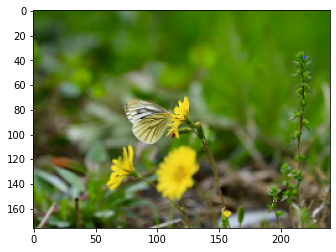

In [16]:
path = list_img_path[image_idx]
im = Image.open(path)
plt.imshow(im)

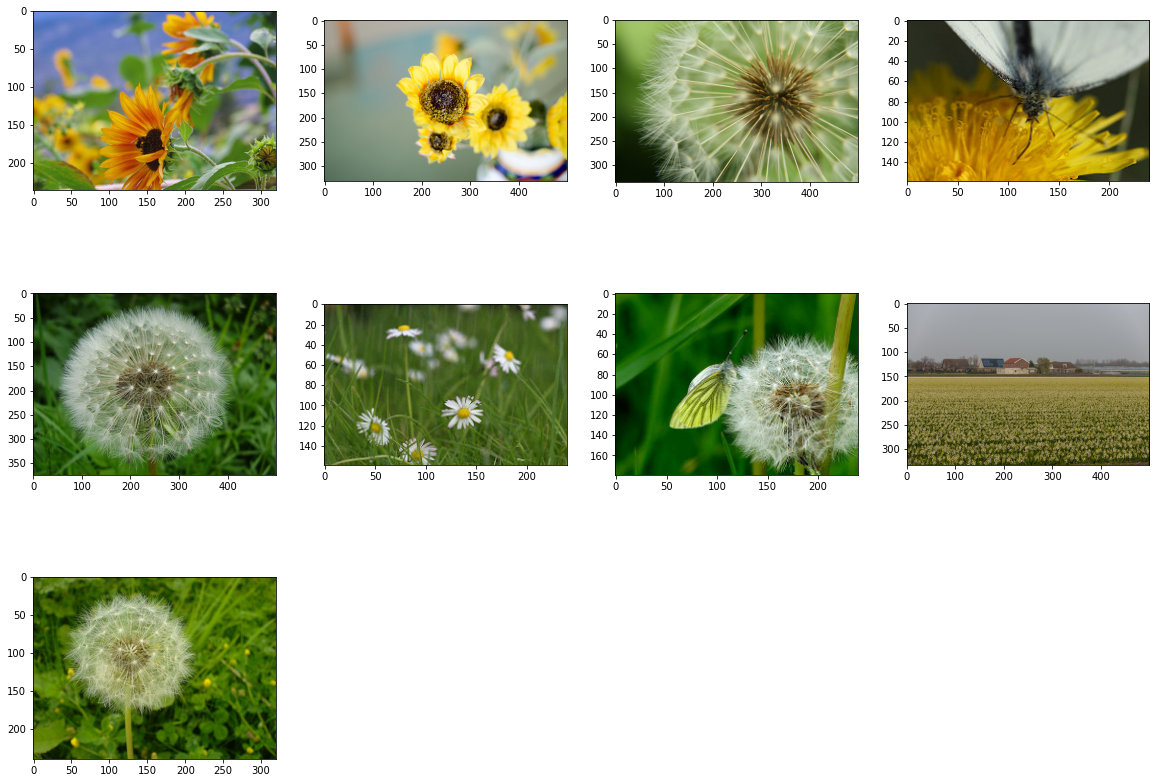

In [18]:
i = 1
columns = 4
rows = 4
fig = plt.figure(figsize=(20, 20))

for idx in similar_result[0][1:]:
    path = list_img_path[idx]
    im = Image.open(path)

    fig.add_subplot(rows, columns, i)
    plt.imshow(im)
    i += 1

plt.show()